In [1]:
from random import randrange
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from pandas.plotting import lag_plot, autocorrelation_plot
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
fem_birth = pd.read_csv(r'C:\Users\Ankit Panday\Downloads\daily_total_female_births.csv',index_col=0,parse_dates=True)

In [3]:
series = fem_birth.squeeze()

In [4]:
series.head()

date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
Name: births, dtype: int64

In [5]:
print(series.tail())

date
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: births, dtype: int64


In [6]:
print(series.isna().sum())

0


In [7]:
print(series.index.duplicated().sum())

0


In [8]:
print(series.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 365 entries, 1959-01-01 to 1959-12-31
Series name: births
Non-Null Count  Dtype
--------------  -----
365 non-null    int64
dtypes: int64(1)
memory usage: 13.8 KB
None


In [9]:
series.describe()

count    365.000000
mean      41.980822
std        7.348257
min       23.000000
25%       37.000000
50%       42.000000
75%       46.000000
max       73.000000
Name: births, dtype: float64

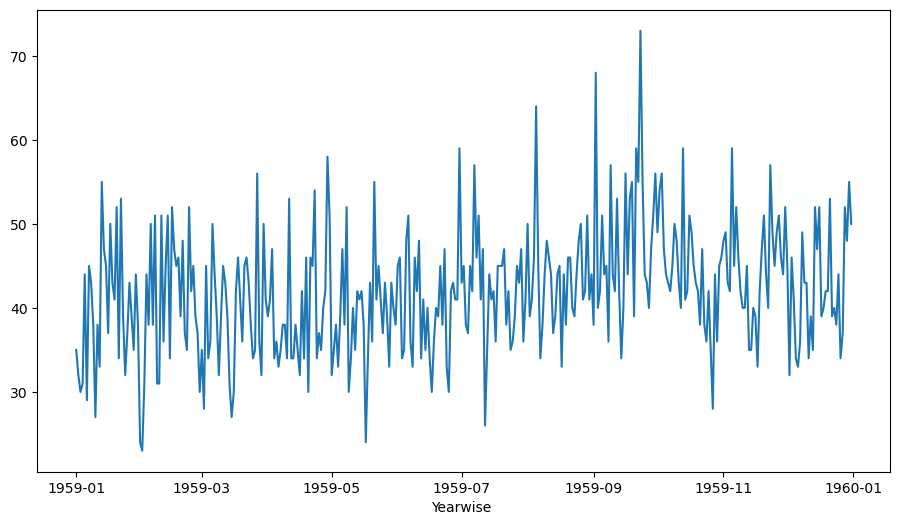

In [11]:
plt.figure(figsize=(11,6))
plt.xlabel("Yearwise ")
plt.plot(series)

In [15]:
series1 = series[:'1959-03']

In [16]:
series1

date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-03-27    56
1959-03-28    36
1959-03-29    32
1959-03-30    50
1959-03-31    41
Name: births, Length: 90, dtype: int64

Text(0, 0.5, 'Female Birth')

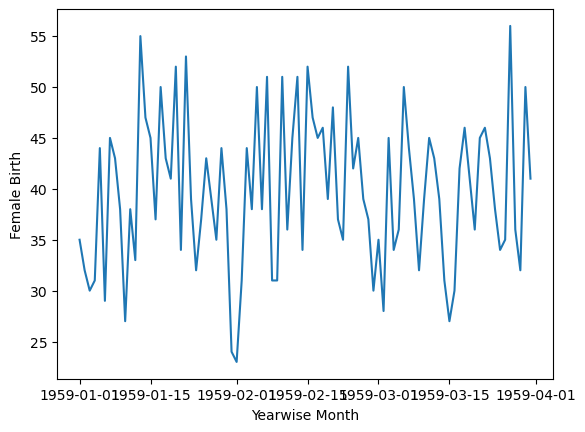

In [18]:
plt.plot(series1)
plt.xlabel('Yearwise Month')
plt.ylabel("Female Birth")

(array([  6.,  22.,  71., 100.,  95.,  43.,  20.,   5.,   1.,   2.]),
 array([23., 28., 33., 38., 43., 48., 53., 58., 63., 68., 73.]),
 <BarContainer object of 10 artists>)

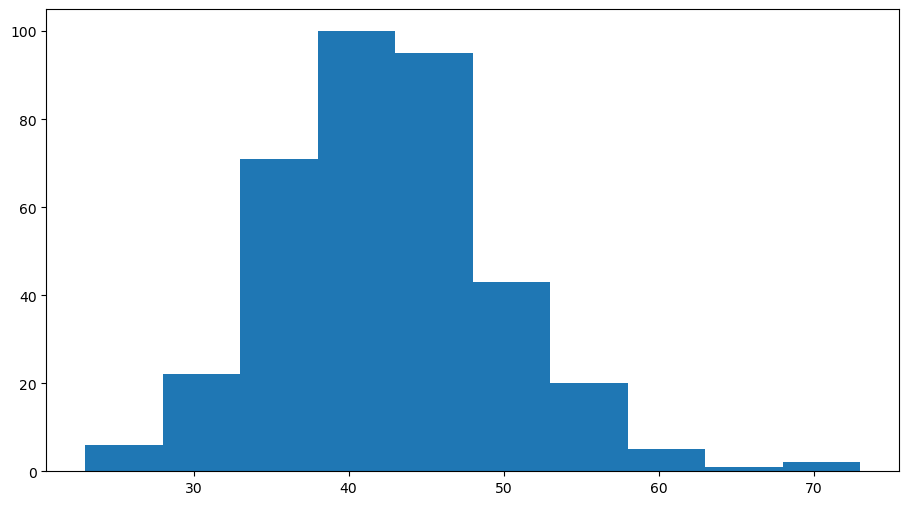

In [77]:
plt.figure(figsize=(11,6))
plt.hist(series)

[]

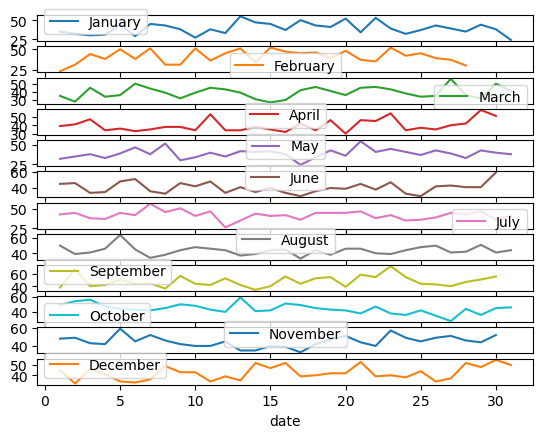

In [25]:
groups = series.groupby(pd.Grouper(freq='M'))
months = pd.DataFrame()
for i,j in groups:
   
   month_name = i.strftime('%B')
    # Reset the index to get the day of the month as the index
   day_of_month = j.index.day
    # Store each month's data in the DataFrame
   months[month_name] = pd.Series(j.values.flatten(), index=day_of_month)
months.plot(subplots=True, legend=True)
plt.plot()

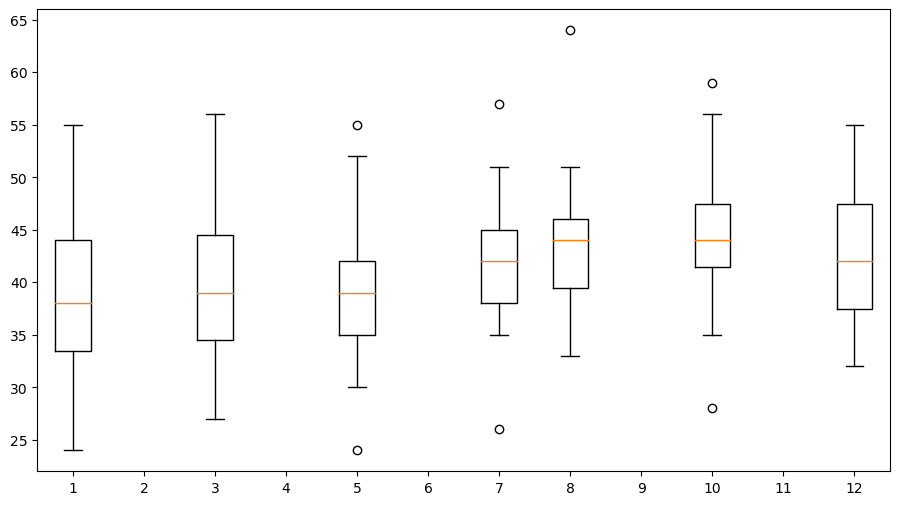

In [26]:
plt.figure(figsize=(11,6))
plt.boxplot(months)
plt.plot();

# Stationary Check

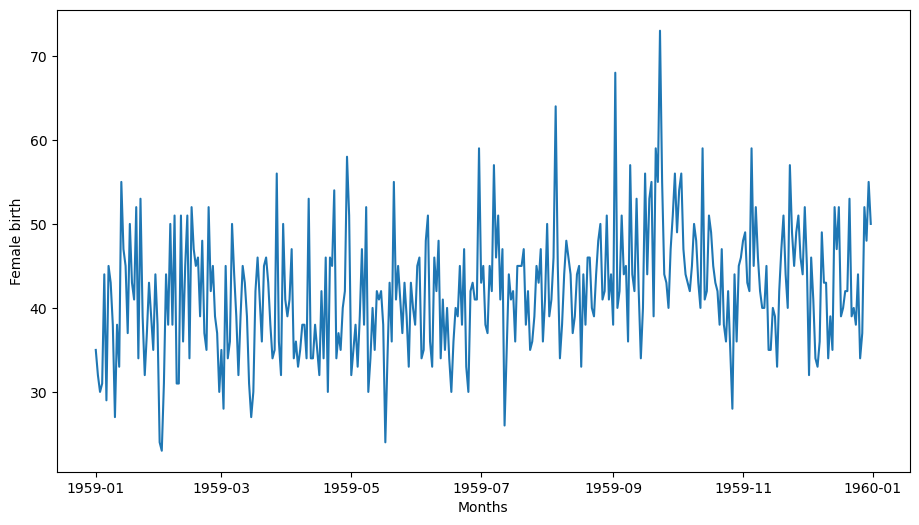

In [44]:
plt.figure(figsize=(11,6))
plt.xlabel('Months')
plt.ylabel("Female birth")
plt.plot(series)

In [42]:
# 1 Summary statistics

series.describe()
# this is additional

count    365.000000
mean      41.980822
std        7.348257
min       23.000000
25%       37.000000
50%       42.000000
75%       46.000000
max       73.000000
Name: births, dtype: float64

In [43]:
X  = series.values
split = int(len(X)/2)
x1,x2 = X[:split],X[split:]
mean1, mean2 = x1.mean(),x2.mean()
var1,var2 = x1.var(),x2.var()

print('mean1=%f, mean2=%f'%(mean1,mean2))
print('var1=%f, var2 = %f'%(var1,var2))

mean1=39.763736, mean2=44.185792
var1=49.213410, var2 = 48.708651


 means and variance are not same same but in the same ball-park so we should use statistical test to see whther it is stationary or not

In [45]:
# adfuller test

result = adfuller(series)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1]>0.05:
   print("Non Stationary")
else:
   print("Stationary")

ADF Statistic: -4.808291253559765
p-value: 5.2434129901498554e-05
Stationary


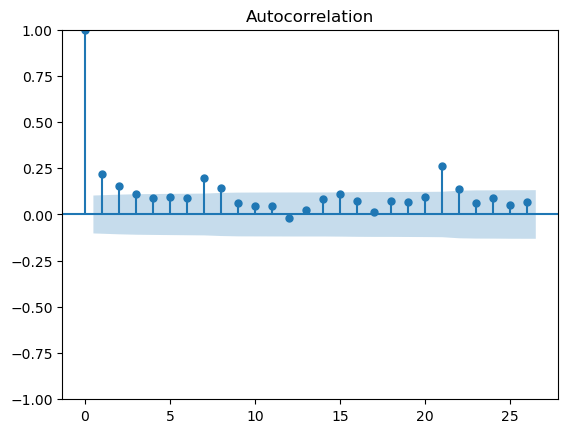

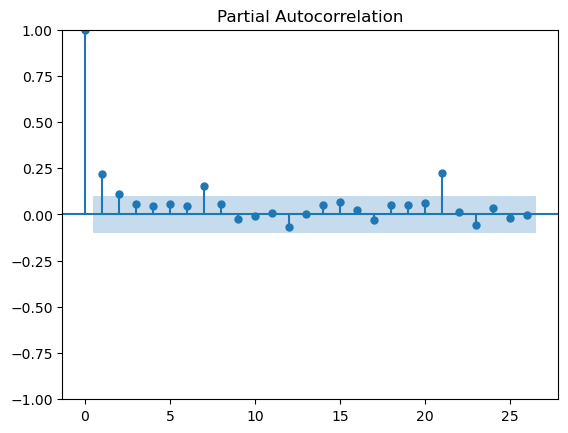

In [47]:
plot_acf(series);
plot_pacf(series);

# Persistence Model

In [27]:
# creating lag feature
temps = pd.DataFrame(series.values)
dataframe = pd.concat([temps.shift(1), temps], axis= 1)
dataframe.columns = ['t(x)','t+1(y)']
dataframe.head()

,t(x),t+1(y)
0,NaN,35
1,35.0,32
2,32.0,30
3,30.0,31
4,31.0,44


In [33]:
# Date time Feature
temps = pd.DataFrame(series.values)
dataframe = pd.DataFrame()
dataframe['month'] = [series.index[i].month for i in range(len(series))]
dataframe['day'] = [series.index[i].day for i in range(len(series))]
dataframe['fem_birth'] = [series[i] for i in range(len(series))]
print(dataframe.head(5))

   month  day  fem_birth
0      1    1         35
1      1    2         32
2      1    3         30
3      1    4         31
4      1    5         44


In [34]:
# rolling window
temps = pd.DataFrame(series.values)
shifted= temps.shift(1)
window = shifted.rolling(window=2)
means = window.mean()
dataframe = pd.concat([means, temps], axis=1)
dataframe.columns  = ['mean(t-1,t)','t+1']
dataframe.head()


,"mean(t-1,t)",t+1
0,NaN,35
1,NaN,32
2,33.5,30
3,31.0,31
4,30.5,44


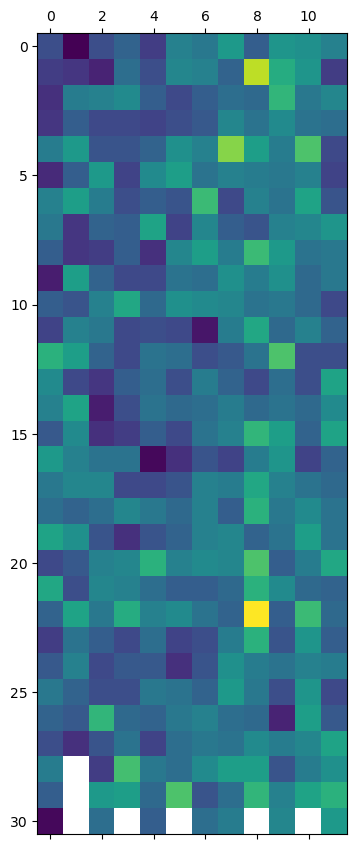

In [28]:
plt.matshow(months, interpolation = None, aspect = 'auto')
plt.show()

In [35]:

upsample = series.resample('D').mean()
upsample.head()

date
1959-01-01    35.0
1959-01-02    32.0
1959-01-03    30.0
1959-01-04    31.0
1959-01-05    44.0
Freq: D, Name: births, dtype: float64

date
1959-01-01    35.0
1959-01-02    32.0
1959-01-03    30.0
1959-01-04    31.0
1959-01-05    44.0
1959-01-06    29.0
1959-01-07    45.0
1959-01-08    43.0
1959-01-09    38.0
1959-01-10    27.0
1959-01-11    38.0
1959-01-12    33.0
1959-01-13    55.0
1959-01-14    47.0
1959-01-15    45.0
1959-01-16    37.0
1959-01-17    50.0
1959-01-18    43.0
1959-01-19    41.0
1959-01-20    52.0
1959-01-21    34.0
1959-01-22    53.0
1959-01-23    39.0
1959-01-24    32.0
1959-01-25    37.0
1959-01-26    43.0
1959-01-27    39.0
1959-01-28    35.0
1959-01-29    44.0
1959-01-30    38.0
Freq: D, Name: births, dtype: float64


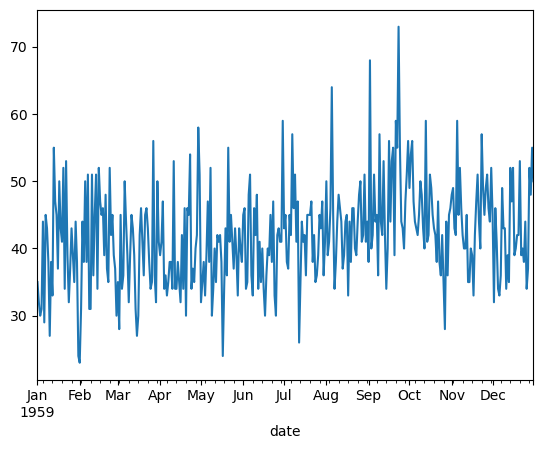

In [36]:
upsample = series.resample('D').mean()
interpolated = upsample.interpolate(method='linear')
print(interpolated.head(30))
interpolated.plot()
plt.show()

date
1959-01-31    39.129032
1959-02-28    41.000000
1959-03-31    39.290323
1959-04-30    39.833333
1959-05-31    38.967742
1959-06-30    40.400000
1959-07-31    41.935484
1959-08-31    43.580645
1959-09-30    48.200000
1959-10-31    44.129032
1959-11-30    45.000000
1959-12-31    42.387097
Freq: M, Name: births, dtype: float64


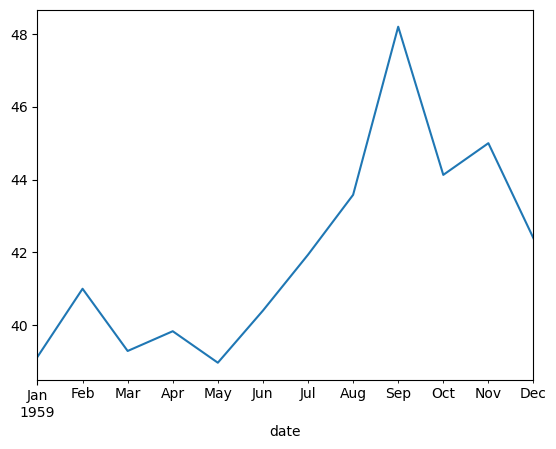

In [39]:
upsample = series.resample('M').mean()
interpolated = upsample.interpolate(method='linear')
print(interpolated.head(32))
interpolated.plot()
plt.show()

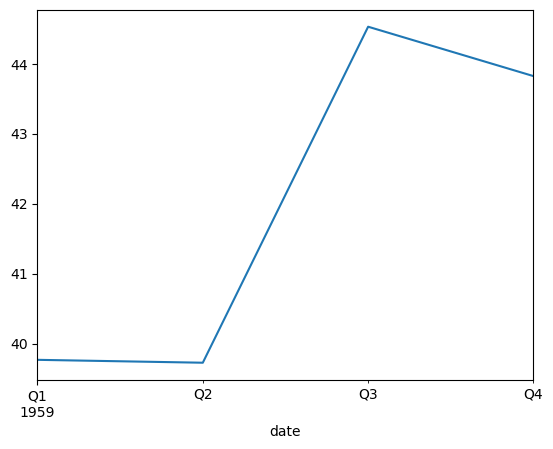

In [40]:
downsampling = series.resample('Q').mean()
downsampling.head()
downsampling.plot()
plt.show()

Test RMSE: 9.151


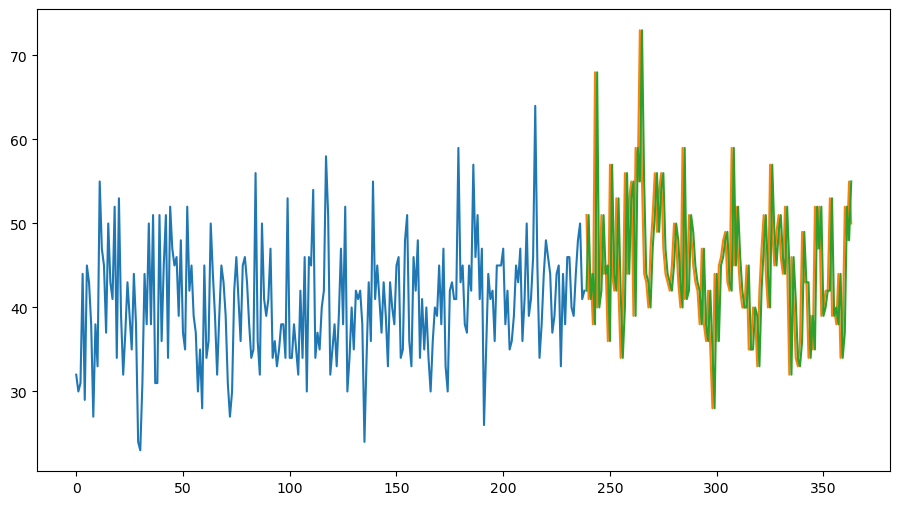

In [54]:
# Pesistence Model

Values = pd.DataFrame(series.values)
dataframe = pd.concat([Values.shift(1),Values], axis = 1)
dataframe.columns= ['t','t+1']
dataframe.head()


# Spliting the data into train and test sets
X= dataframe.values
train_size = int(len(X)*0.66)
train, test = X[1:train_size], X[train_size:]
train_x, train_y = train[:,0],train[:,1]
test_x, test_y = test[:,0],test[:,1]


# persistence model
def model_persistence(x):
   return(x)

# Walk forwar validation
predictions = list()
for x in test_x:
   yhat = model_persistence(x)
   predictions.append(yhat)
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' %rmse)

plt.figure(figsize=(11,6))
plt.plot(train_y)
plt.plot([None for i in train_y]+[x for x in test_y])
plt.plot([None for i in train_y]+[x for x in predictions])
plt.show()


In [61]:

model1 = ARIMA(series,order=(1,0,1))

C:\Users\Ankit Panday\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Ankit Panday\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Ankit Panday\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [62]:
model1_fit = model1.fit()

In [63]:
predictions1 = model1_fit.predict(steps = len(series))

In [64]:
MAPE = mean_absolute_percentage_error(series,predictions)
print("MAPE: ", MAPE *100)

MAPE:  14.25719229705529


In [65]:
model2 = ARIMA(series, order=(1,0,0))
model2_fit = model2.fit()
predictions2 = model2_fit.predict(steps = len(series))
MAPE = mean_absolute_percentage_error(series, predictions2)
print("MAPE: ",MAPE*100)

MAPE:  14.25719229705529


C:\Users\Ankit Panday\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Ankit Panday\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Ankit Panday\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [66]:
model3 = ARIMA(series, order=(0,0,0))
model3_fit = model3.fit()
predictions3 = model3_fit.predict(steps = len(series))
MAPE = mean_absolute_percentage_error(series, predictions3)
print("MAPE: ",MAPE*100)

MAPE:  14.25719229705529


C:\Users\Ankit Panday\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Ankit Panday\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Ankit Panday\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


# Residual Analysis

In [68]:
residuals = series - predictions1

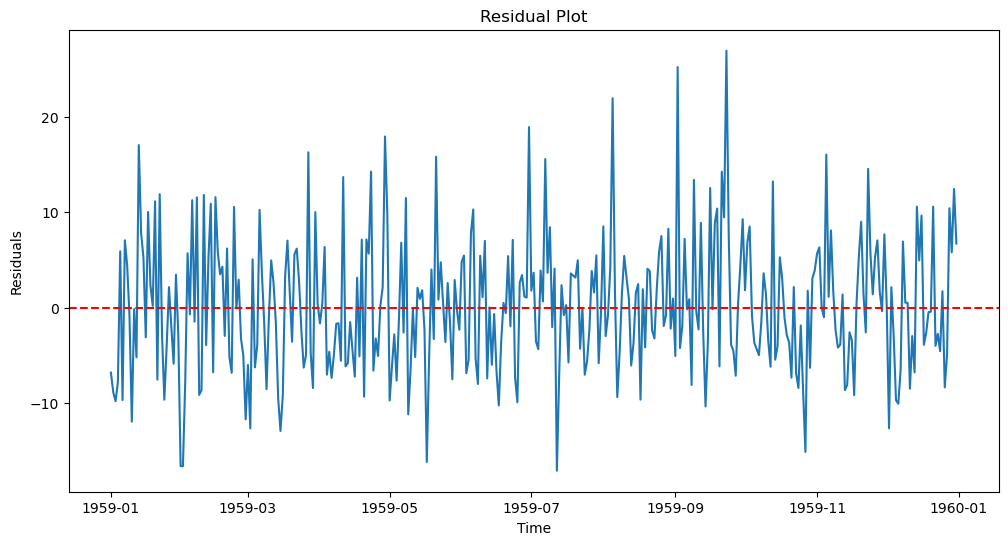

In [69]:
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.axhline(0,color= 'red',linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

<Axes: ylabel='Frequency'>

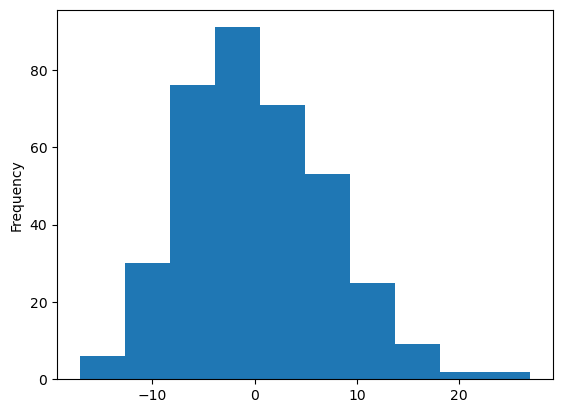

In [70]:
model1_fit.resid.plot.hist()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

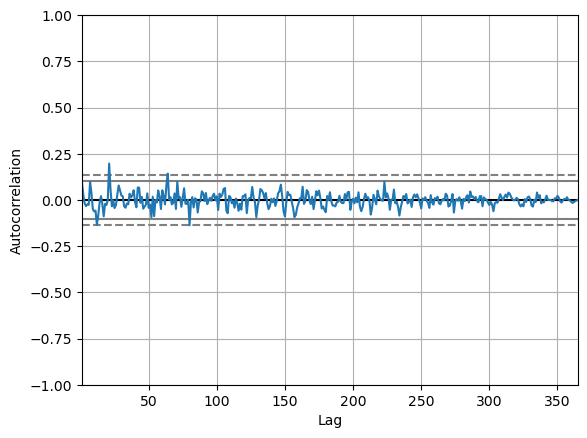

In [71]:
autocorrelation_plot(residuals)

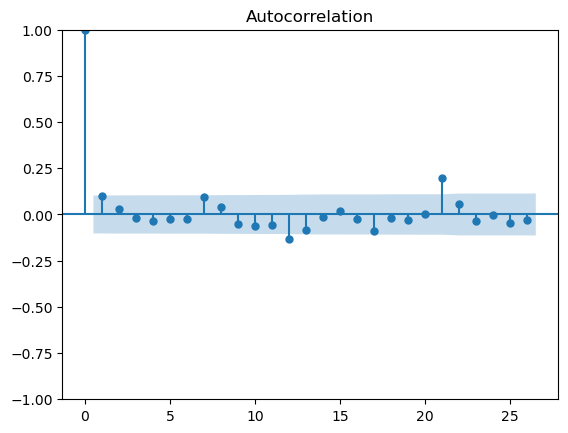

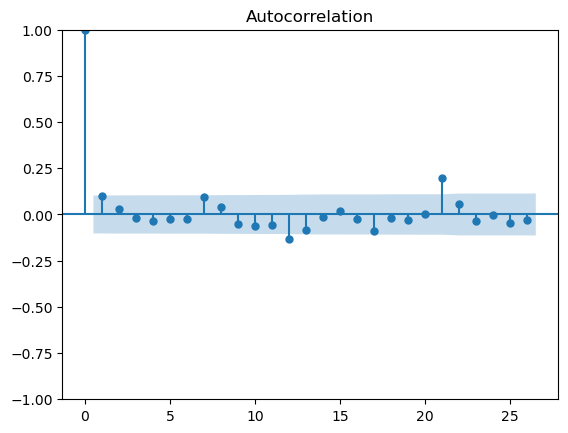

In [72]:
plot_acf(residuals)

In [73]:
print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 births   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1230.453
Date:                Mon, 21 Oct 2024   AIC                           2468.906
Time:                        20:31:19   BIC                           2484.505
Sample:                    01-01-1959   HQIC                          2475.105
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.8289      1.438     29.079      0.000      39.010      44.648
ar.L1          0.9800      0.017     56.392      0.000       0.946       1.014
ma.L1         -0.9199      0.035    -26.294      0.0

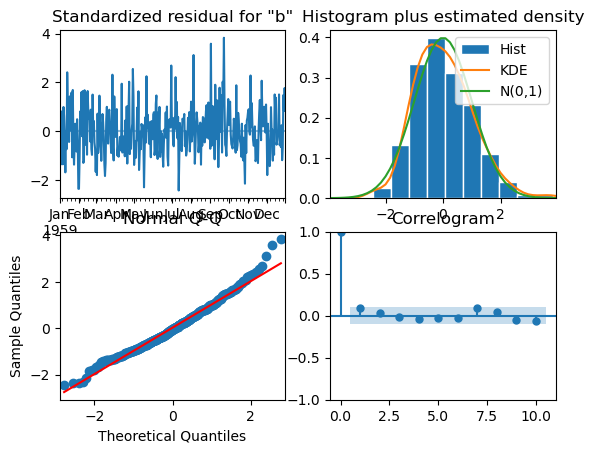

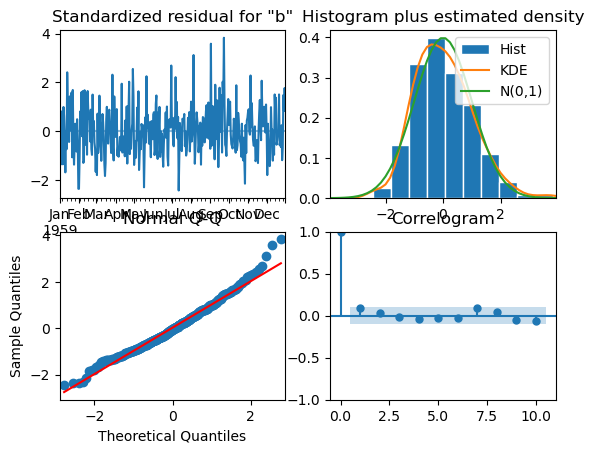

In [75]:
model1_fit.plot_diagnostics()